<a href="https://colab.research.google.com/github/amthreeh/ComputerVision_Seminar/blob/main/%EA%B3%BC%EC%A0%9C/4w_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B_%ED%81%B4%EB%9E%98%EC%8A%A4_%EC%BB%A4%EC%8A%A4%ED%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4주차 - Pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [4]:
import torch
import torchvision
from torchvision import transforms
import os
import glob


device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [6]:
root_path = '/content/drive/MyDrive/CV_seminar_project/'
train_path='/content/drive/MyDrive/CV_seminar_project/train'
test_path='/content/drive/MyDrive/CV_seminar_project/test'

dolphin_dir = '/dolphin'
shark_dir = '/shark'
whale_dir = '/whale'

# pytorch 데이터셋 클래스 실습

### 파이토치 데이터셋 클래스 직접 만들기
1. __init__ 생성자가 필요함.
2. __getitem__ 필요함. -> 데이터를 읽는 역할(인덱스 부여, iterable)
2. __len__ 필요함. -> 데이터 개수를 알려주는 역할

In [7]:
from torch.utils.data import Dataset, DataLoader  #커스터마이징
import cv2

class Custom_dataset(Dataset):   #mode -> 데이터 셋 종류
  def __init__(self, root_path, mode, transform=None): #생성자 특수메소드
    self.all_data = sorted(glob.glob(os.path.join(root_path, mode, '*', '*'))) #모든 데이터 경로의 리스트
    self.transform = transform #augmentation

  def __getitem__(self, index):

    if torch.is_tensor(index):
      index = index.tolist()

    #이미지 읽기
    data_path = self.all_data[index]
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #채널 축: BGR > RGB

    #transform (Augmentation)
    if self.transform is not None:
      augmentation = self.transform( image = image )
      image = augmentation['image']

    #label 만들어주기
    label = []
    if 'dolphin' in data_path.split('/')[-1]:
      label = 0
    elif 'shark' in data_path.split('/')[-1]:
      label = 1
    else:
      label = 2

    return image, label #입출력함수

  def __len__(self):
    length = len(self.all_data)  #전체 데이터 개수
    return length


In [33]:
root_path = '/content/drive/MyDrive/CV_seminar_project/'
train_path='/content/drive/MyDrive/CV_seminar_project/train'
test_path='/content/drive/MyDrive/CV_seminar_project/test'

dolphin_dir = '/dolphin'
shark_dir = '/shark'
whale_dir = '/whale'
from google.colab.patches import cv2_imshow
from PIL import Image as PILImage

original_dataset = Custom_dataset(root_path = root_path, mode = 'train',transform=None)

#과제1 - 4주차

In [32]:
import albumentations
import albumentations.pytorch

#Compose: 여러개 적용
albumentations = albumentations.Compose( [
    albumentations.Resize(224, 224),
    #뒤집기, 돌리기
    albumentations.OneOf([
        albumentations.HorizontalFlip(p=0.8),
        albumentations.VerticalFlip(p=0.8),
        albumentations.RandomRotate90(p=0.8),
        albumentations.ShiftScaleRotate(shift_limit=0.4, scale_limit=(0.5, 0.9), rotate_limit=90, p=0.8, border_mode=cv2.BORDER_REPLICATE),
        #shift, scale, rotate를 한번에 적용
    ], p = 1), 
    #픽셀값 장난질
    albumentations.OneOf([
        #albumentations.ChannelShuffle(p=0.8), #색상, 채도, 명도 변경
        albumentations.RGBShift(r_shift_limit=70, g_shift_limit=50, b_shift_limit=100, p=0.8), #RGB값 변경
        albumentations.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #밝기, 대조, 채비, 색조조
        albumentations.MotionBlur(p=0.8),  #흐리게
        albumentations.OpticalDistortion(p=0.8),  #왜곡
        albumentations.GaussNoise(p=0.8), #노이즈 추가
    ], p = 1),

    # albumentations.pytorch.transforms.ToTensor()  #0 - 1 만들기기
]
)

pytorch_dataset = Custom_dataset(root_path = root_path, mode = 'train', transform=albumentations)

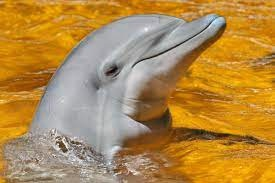

In [43]:
cv2_imshow(original_dataset[4][0])

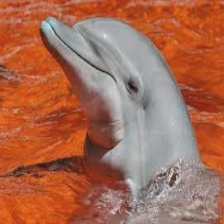

In [42]:
cv2_imshow(pytorch_dataset[4][0])

p = 0.5, 확률값을 0.5로 주면 바뀐 것도 있고 바뀌지 않은 것도 있습니다. 